# 필요한 모듈 불러오기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 인물모드 직접 해보기

# 이미지 불러오기

(831, 828, 3)


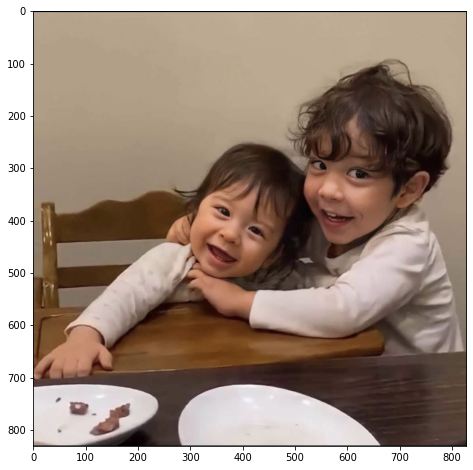

In [2]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/aciel_elyseen.JPG'
img_orig_a = cv2.imread(img_path)


print(img_orig_a.shape)
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(img_orig_a, cv2.COLOR_BGR2RGB))
plt.show()

# 세그멘테이션으로 사람 분리하기

## 시맨틱 세그멘테이션 (Semantic Segmentation)
- 물리적 의미 단위로 인식하는 세그멘테이션
- 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(Classification)

**PixelLib에서 제공해 주는 모델을 다운로드하는 코드**
- 사전에 진행했으므로 따로 실행시키지 않음

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f18e28fe850>)

# 모델 생성

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지 입력

In [5]:
segvalues_a, output_a = model.segmentAsPascalvoc(img_path)

### PASCAL VOC 데이터의 라벨 종류

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

## 사람(Person) 라벨, 15번 영역 검출

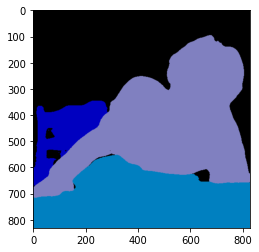

In [7]:
plt.imshow(output_a)
plt.show()

In [8]:
segvalues_a

{'class_ids': array([ 0,  9, 11, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [9]:
for class_id in segvalues_a['class_ids']:
    print(LABEL_NAMES[class_id])
    
#output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨있음
#segvalues에는 class_ids와 masks가 있음

background
chair
diningtable
person


## 물체마다 output에 어떤 색상으로 나타나 있는지 확인

In [10]:
colormap_a = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap_a[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap_a[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

- 사람을 나타내는 15번째 색상

In [11]:
colormap_a[15]

array([192, 128, 128])

- 의자를 나타내는 9번째 색상

In [12]:
colormap_a[9]

array([192,   0,   0])

## output 이미지 RGB 순서 바꿔주기

In [13]:
seg_color_a = (128, 128, 192)

(831, 828)


<function matplotlib.pyplot.show(close=None, block=None)>

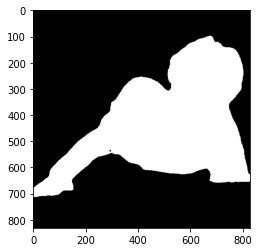

In [14]:
seg_map_a = np.all(output_a==seg_color_a, axis = -1)
print(seg_map_a.shape)

plt.imshow(seg_map_a, cmap='gray')
plt.show

# 1: 흰색
# 0: 검은색

## 원래 이미지와 겹쳐보기

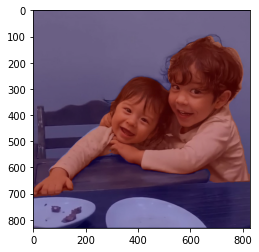

In [15]:
img_show_a = img_orig_a.copy()

#True와 False인 값을 각각 255와 0으로 바꿔줌 -> 컬러의 범위는 0부터 255니까
img_mask_a = seg_map_a.astype(np.uint8) * 255

#255와 0을 적당한 색상으로 바꿔봄
color_mask_a = cv2.applyColorMap(img_mask_a, cv2.COLORMAP_JET)

#원본 이미지와 마스크를 적당히 합쳐봄
#0.6과 0.4는 두 이미지를 섞는 비율
img_show_a = cv2.addWeighted(img_show_a, 0.6, color_mask_a, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_a, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 흐리게 하기
- blur() 함수 이용

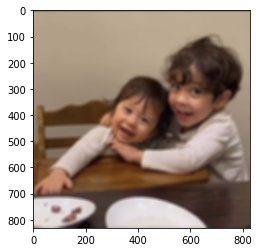

In [16]:
img_orig_blur_a = cv2.blur(img_orig_a, (15, 15))
                                      #블러 처리를 얼마나 뿌옇게 할 건지
plt.imshow(cv2.cvtColor(img_orig_blur_a, cv2.COLOR_BGR2RGB))
plt.show()

## 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출

- bitwise_not() : 이미지를 반전시키는 역할
- 원래 마스크에서는 배경이 0 사람이 255지만, 연산을 하고 나면 배경은 255 사람이 0

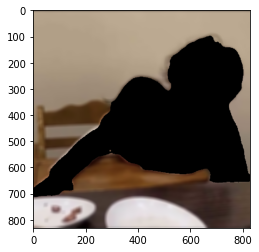

In [17]:
img_mask_color_a = cv2.cvtColor(img_mask_a, cv2.COLOR_GRAY2BGR)
img_bg_mask_a = cv2.bitwise_not(img_mask_color_a)   #사람이 0

img_bg_blur_a = cv2.bitwise_and(img_orig_blur_a, img_bg_mask_a)

plt.imshow(cv2.cvtColor(img_bg_blur_a, cv2.COLOR_BGR2RGB))
plt.show()

#반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 얻을 수 있음

- 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0 

bitwise.and 연산은 True와 True일 때에만 True를 뱉어냄.

사람을 0으로 처리했으니 False

블러 이미지 값은 True이고, 이미지 마스크에서 사람은 False이기 때문에

사람 부분은 False로 반환

참고 링크 : https://rootiel.tistory.com/22

### numpy.where(조건, 참일 때, 거짓일 때)

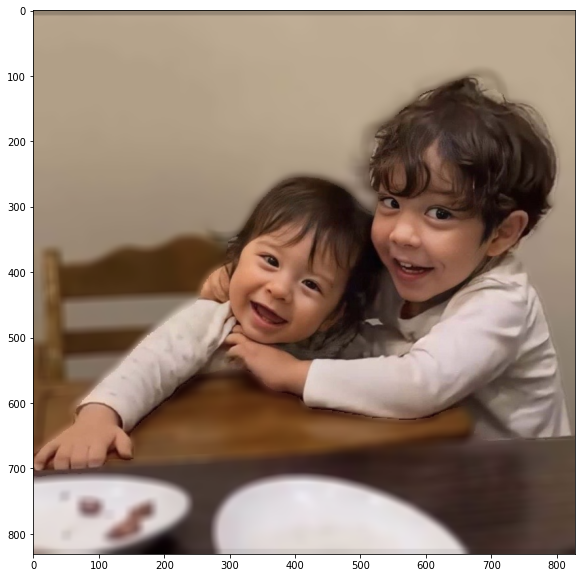

In [18]:
img_concat_a = np.where(img_mask_color_a ==255, img_orig_a, img_bg_blur_a)
plt.figure(figsize=(12,10))
plt.imshow(cv2.cvtColor(img_concat_a, cv2.COLOR_BGR2RGB))
plt.show()

오른쪽 아이의 앞머리 부분이 조금 어색하지만 그 외의 부분은 잘 처리되었다.

# 이미지 불러오기

(961, 720, 3)


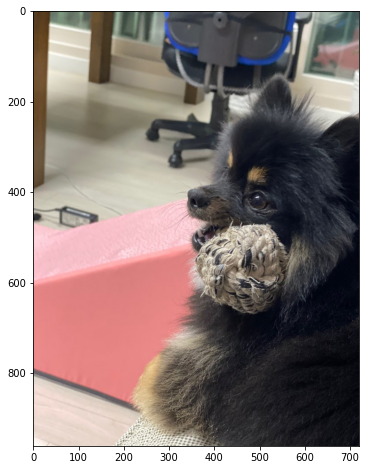

In [19]:
img_path_b = os.getenv('HOME') + '/aiffel/human_segmentation/images/ball_dog.JPG'
img_orig_b = cv2.imread(img_path_b)


print(img_orig_b.shape)
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(img_orig_b, cv2.COLOR_BGR2RGB))
plt.show()

인물 뿐만 아니라 강아지에 대해서도 시멘틱 세그멘테이션을 적용해보고자 한다.

## 세그멘테이션으로 강아지 분리하기

### 시맨틱 세그멘테이션(Semantic Segmentation)

- model을 다운받고 생성하는 과정은 위에서 진행했기 때문에 생략

### 모델 이미지 입력

In [20]:
segvalues_b, output_b = model.segmentAsPascalvoc(img_path_b)

### PASCAL VOC 데이터의 라벨 종류

In [21]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 강아지의 경우 12번

### 강아지(dog) 라벨, 12번 영역 검출

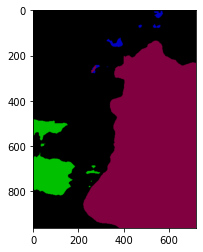

In [22]:
plt.imshow(output_b)
plt.show()

In [23]:
for class_id in segvalues_b['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
dog
sofa


### 물체마다 output에 어떤 색상으로 나타나 있는지 확인

In [24]:
colormap_b = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap_b[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap_b[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

- 강아지를 나타내는 12번째 색상

In [25]:
colormap_b[12]

array([ 64,   0, 128])

## output 이미지 RGB 순서 바꿔주기

In [26]:
seg_color_b = (128, 0, 64)

### output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)¶

(961, 720)


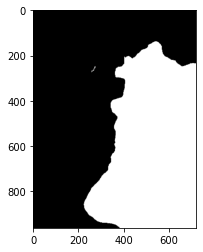

In [27]:
seg_map_b = np.all(output_b==seg_color_b, axis = -1)
print(seg_map_b.shape)

plt.imshow(seg_map_b, cmap='gray')
plt.show()

# 1: 흰색
# 0: 검은색

## 원래 이미지와 겹쳐보기

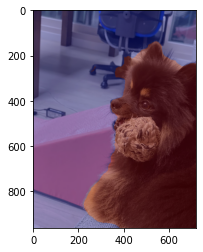

In [28]:
img_show_b = img_orig_b.copy()

img_mask_b = seg_map_b.astype(np.uint8) * 255

color_mask_b = cv2.applyColorMap(img_mask_b, cv2.COLORMAP_JET)

img_show_b = cv2.addWeighted(img_show_b, 0.6, color_mask_b, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_b, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 흐리게 하기
- blur() 함수 이용

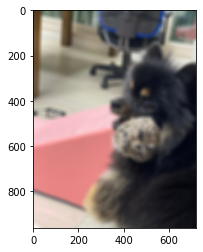

In [29]:
img_orig_blur_b = cv2.blur(img_orig_b, (20, 20))
plt.imshow(cv2.cvtColor(img_orig_blur_b, cv2.COLOR_BGR2RGB))
plt.show()

## 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경 추출

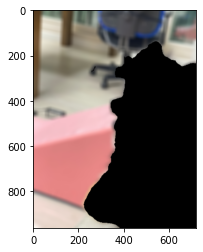

In [30]:
img_mask_color_b = cv2.cvtColor(img_mask_b, cv2.COLOR_GRAY2BGR)
img_bg_mask_b = cv2.bitwise_not(img_mask_color_b)   #강아지가 0

img_bg_blur_b = cv2.bitwise_and(img_orig_blur_b, img_bg_mask_b)

plt.imshow(cv2.cvtColor(img_bg_blur_b, cv2.COLOR_BGR2RGB))
plt.show()

#반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 얻을 수 있음

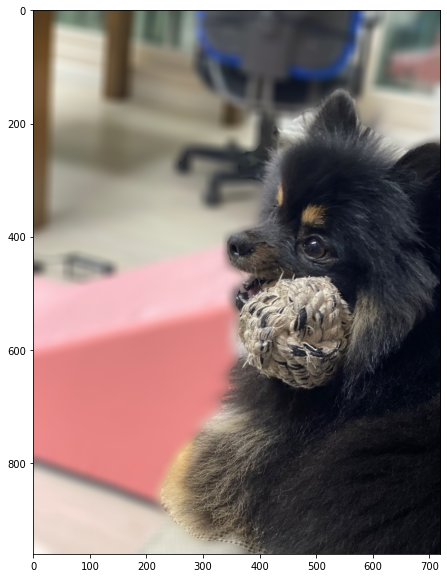

In [31]:
img_concat_b = np.where(img_mask_color_b==255, img_orig_b, img_bg_blur_b)
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(img_concat_b, cv2.COLOR_BGR2RGB))
plt.show()

깔끔하게 잘 진행되었다.

# 이미지 불러오기

(512, 696, 3)


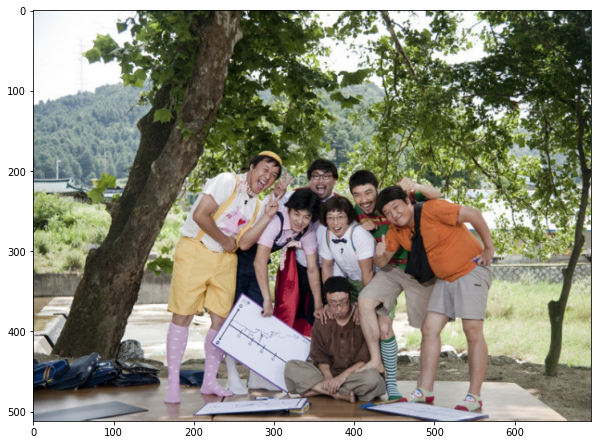

In [32]:
img_path_c = os.getenv('HOME') + '/aiffel/human_segmentation/images/moohan.JPG'
img_orig_c = cv2.imread(img_path_c)


print(img_orig_c.shape)
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(img_orig_c, cv2.COLOR_BGR2RGB))
plt.show()

인물의 얼굴이 화면에서 가깝지 않고, 여러 명일 경우에도 시멘틱 세그멘테이션을 적용해보고자 한다.

# 시맨틱 세그멘테이션으로 사람들 분리

### 모델 이미지 입력

In [33]:
segvalues_c, output_c = model.segmentAsPascalvoc(img_path_c)

## 사람(Person) 라벨, 15번 영역 검출

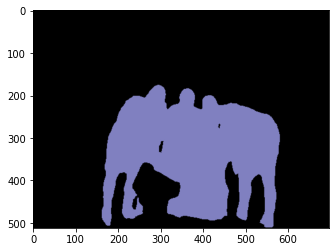

In [34]:
plt.imshow(output_c)
plt.show()

In [35]:
for class_id in segvalues_c['class_ids']:
    print(LABEL_NAMES[class_id])
    
#사람과 배경만 인식

background
person


## 물체마다 output에 어떤 색상으로 나타나 있는지 확인

In [36]:
colormap_c = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap_c[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap_c[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

- 사람을 나타내는 15번째 색상

In [37]:
colormap_c[15]

array([192, 128, 128])

## colormap RGB순서 재배치

In [38]:
seg_color_c = (128, 128, 192)

- np.all(조건) 

  : 배열의 모든 데이터가 조건과 맞으면 True 하나라도 다르면 False


(512, 696)


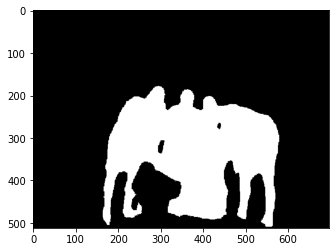

In [39]:
seg_map_c = np.all(output_c ==seg_color_c, axis=-1)
print(seg_map_c.shape)

plt.imshow(seg_map_c, cmap='gray')
plt.show()

## 원래 이미지와 겹쳐보기

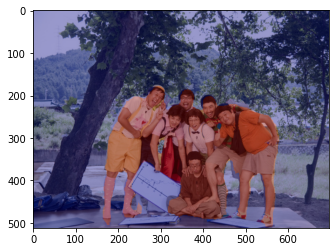

In [40]:
img_show_c = img_orig_c.copy()

img_mask_c = seg_map_c.astype(np.uint8) * 255

color_mask_c = cv2.applyColorMap(img_mask_c, cv2.COLORMAP_JET)

img_show_c = cv2.addWeighted(img_show_c, 0.6, color_mask_c, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_c, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 흐리게 하기

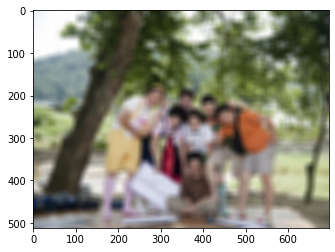

In [41]:
img_orig_blur_c = cv2.blur(img_orig_c, (17,17))
plt.imshow(cv2.cvtColor(img_orig_blur_c, cv2.COLOR_BGR2RGB))
plt.show()

## 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출

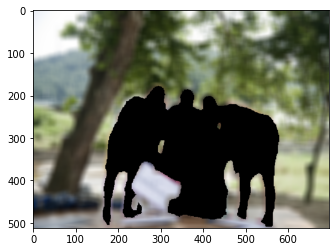

In [42]:
img_mask_color_c = cv2.cvtColor(img_mask_c, cv2.COLOR_GRAY2BGR)
img_bg_mask_c = cv2.bitwise_not(img_mask_color_c)   #사람이 0

img_bg_blur_c = cv2.bitwise_and(img_orig_blur_c, img_bg_mask_c)

plt.imshow(cv2.cvtColor(img_bg_blur_c, cv2.COLOR_BGR2RGB))
plt.show()

## 원본과 비교

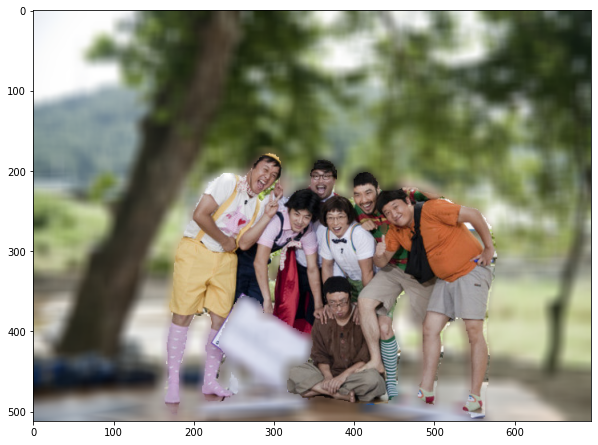

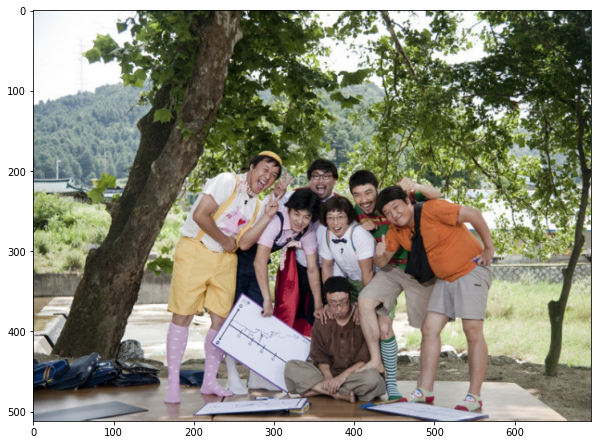

In [43]:
img_concat_c = np.where(img_mask_color_c==255, img_orig_c, img_bg_blur_c)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_concat_c, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(img_orig_c, cv2.COLOR_BGR2RGB))
plt.show()

# 추가 - 크로마키 배경 합성

- 하늘 사진 불러오기

In [45]:
sky_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/sky.JPG'
sky = cv2.imread(sky_path)

In [59]:
print(sky.shape)   # 하늘 사진의 shape
print(img_mask_color_c.shape)   # 무한도전 사진의 shape

(355, 566, 3)
(512, 696, 3)


In [60]:
#하늘 사진의 크기를 무한도전 사진의 크기로 맞춰줌
resized_sky = cv2.resize(sky, dsize=(696, 512), interpolation=cv2.INTER_CUBIC)
print(resized_sky.shape)

(512, 696, 3)


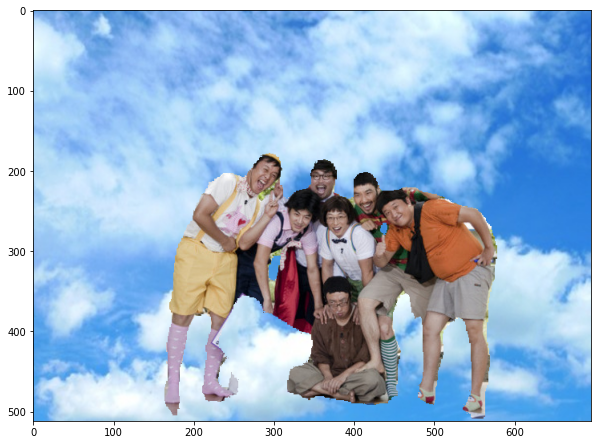

In [61]:
img_concat_d = np.where(img_mask_color_c==255, img_orig_c, resized_sky)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_concat_d, cv2.COLOR_BGR2RGB))
plt.show()

# 이상한 위치를 표시하기 위해 블러처리 한 이미지 저장

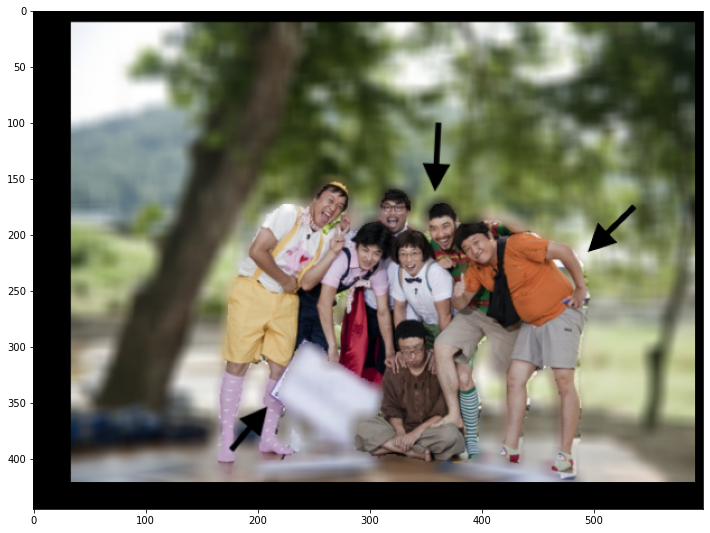

In [47]:
check_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/moohan_final.png'
check = cv2.imread(check_path)

plt.figure(figsize=(12,10))
plt.imshow(cv2.cvtColor(check, cv2.COLOR_BGR2RGB))
plt.show()

1. 정형돈(맨 오른쪽 주황색 옷)의 경우, 팔과 다리 부분에 블러처리가 깔끔하게 완성되지 않았다. 

    정준하(노란색 멜빵 바지)와 비교해보면 미흡한 블러처리가 확연히 나타난다. 


2. 정형돈의 팔 안쪽은 배경임에도 모두 블러처리 되지 않았다.


3. 전진(분홍색 카라티셔츠)이 잡고있는 하얀색 네모판(정준하의 정강이 부분)이 제대로 블러처리가 진행되지 않았다.


4. 노홍철(정형돈 옆 줄무늬 티셔츠)의 머리 일부분이 블러처리 되었다.

# 해결방안 제안

시맨틱 세그멘테이션(semantic segmentation)은 물리적 의미 단위로 인식하는 세그멘테이션이다.

즉, 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 것이다.

위의 사진은 사람을 제외한 배경 부분이 블러처리 되었지만, 일부분은 제대로 블러처리가 되지 못한 채 부자연스러운 형태로 남아있다.

이는 사진 촬영의 개념으로 접근했을 때, 일부분은 **'심도'가 깊게 형성되지 않은 것**으로 볼 수 있다.

이를 보완하기 위해 **구글의 struct2Depth**에서 아이디어를 얻어 이를 활용한 해결 방안을 제안한다.

**struct2Depth** 방식을 온전히 이해하진 못했지만,

물체의 범주에 따라 **각 물체의 규모에 대한 손실을 정의**한다는 것을 활용하여 

블러 처리가 잘 되지 않는 문제점의 해결 방안을 제안하고자 한다.

참고 링크 : https://ichi.pro/ko/jayul-juhaeng-ui-gip-i-insig-27283241983446

**Monodepth2**는 

깊이를 측정하기 위해 한 프레임에서 다음 프레임까지 **픽셀의 차이를 사용하는 비지도 심층 학습 접근 방식**으로

**중요하지 않은 픽셀에 대한 초점을 제거하는 자동 마스킹 기술**을 구현할 수 있다.

이를 활용하여 자동적으로 마스킹을 진행한 후 물체 크기를 인식하도록 모델을 실제로 훈련을 하게 되면 

물체의 범주에 따라 각 물체의 규모에 대한 손실을 정의한다.

그 후 각 규모에서 개별 손실을 결합해 

낮은 해상도의 깊이 맵을 더 높은 입력 이미지 해상도로 업샘플링 한 다음 

더 높은 입력 해상도에서 오류를 계산한다. 

이를 통해 높은 해상도로 정확하게 대상 이미지를 재구성할 수 있다.

따라서 이러한 방법으로 높은 해상도로 이미지를 인식하여 기존의 semantic segmentation보다 

객체 간의 차이를 명확히 구분하고 깊은 심도를 구현할 수 있을 것이라 예상된다.


- 위 과정을 도식화하면 아래와 같다.

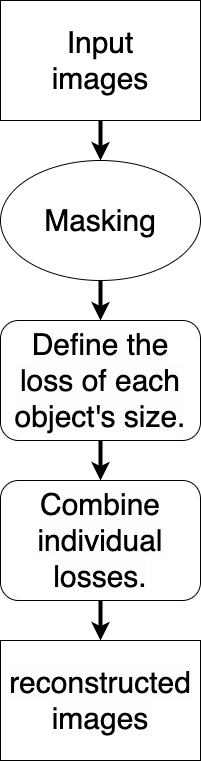

In [63]:
from PIL import Image
from skimage.transform import resize
 
diagram = Image.open("human_segmentation/images/flowchart.png")
diagram.show()

# 회고

LMS를 진행할 때, 여자 성인의 사진을 사용했기 때문에

프로젝트를 진행할 땐 아기, 동물(강아지), 멀리서 찍은 단체사진에 segmentation을 진행해보았다.

처음 귀여운 두 아기 사진과 강아지 사진에서는 segmentation이 잘 진행돼서 

어떤 문제점을 찾아야 하나 고민했는데,

무한도전 단체사진에서는 아주 명확하게 문제점이 드러나 고민이 해결되었다.

아무래도 여러명이고 카메라에서 멀리 있으며 뒷배경이 자연이기 때문에 사람과 배경을 구분하는 것이 

기계가 하기에 어려운 일이었을 것이라고 예상된다.

이러한 문제점을 보완하기 위해 LMS에 올라온 링크들을 하나하나 읽어보았다.

'심도'의 개념, 조리개의 역할, 빛의 중요도 등 사진을 찍는 데에 필요한 개념들은 이해하기 쉬웠으나,

딥러닝을 활용한 기술의 설명은 이해하기 어려웠다.

'난 어쩔 수 없는 문과인걸까' 하는 탄식이 나왔지만 그래도 이해가 될 때까지 계속해서 읽어보았고,

그나마 구글의 struct2Depth 기술이 이해되었다. 

기술의 매커니즘을 온전히 이해한 것은 아니지만,

어느 정도 기술이 구현되는(흘러가는?) 느낌(?)을 파악했고,

semantic segmentation이 갖는 문제에 대한 해결방안을 구상했다.

이번 프로젝트를 통해 새삼스럽지만 나의 부족함을 다시 한 번 느끼게 되었다.

하지만 이제 한 달차이다. 지금과 같은 학습량이면 5개월 후에는 더 성장해있을 것이라 믿는다.

지치지않고 끝까지 열심히 잘 해냈으면 좋겠다.

실력이 많이 늘었으면 좋겠다!